<a href="https://colab.research.google.com/github/montimaj/Deep-Learning-SE-6213/blob/master/HW4/HW4_Sayantan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Abstract:** Effective monitoring of groundwater withdrawals is necessary to help mitigate the negative impacts of aquifer depletion. In this study, we develop a holistic approach that combines water balance components with a machine learning model to estimate groundwater withdrawals. We use both multi-temporal satellite and modeled data from sensors that measure different components of the water balance at varying spatial and temporal resolutions. These remote sensing products include evapotranspiration, precipitation, and land cover. Due to the inherent complexity of integrating these data sets and subsequently relating them to groundwater withdrawals using physical models, we apply state of the art deep learning techniques to overcome such limitations. Here, we predict groundwater withdrawals per unit area over the entire states of Kansas and Arizona.

*Publication Under Review:* https://www.essoar.org/doi/abs/10.1002/essoar.10503273.1

*Current Goals:* Submitting the ML/DL-based paper done in this course to [Remote Sensing of Environment](https://www.journals.elsevier.com/remote-sensing-of-environment) (Elsevier) journal.

*Future Goals:* Applying this approach as part of the [USGS Mississippi Alluvial Plain (MAP)](https://www.usgs.gov/centers/lmg-water/science/mississippi-alluvial-plain-map-water-availability-study-0) project. I will be officially involved in the MAP Water Use team starting January 2021 under a cooperative agreement with the USGS.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/My Drive/SysEng 6213 Fall 2020 Sayantan Majumdar /HW4/Data'
!ls

[Errno 2] No such file or directory: 'drive/My Drive/SysEng 6213 Fall 2020 Sayantan Majumdar /HW4/Data'
/content/drive/.shortcut-targets-by-id/1xpWpUfn0NqGtbgAP_303jr6QW5RKzJPR/SysEng 6213 Fall 2020 Sayantan Majumdar /HW4/Data
GW_DF_KS_AZ.csv


I generated this CSV file after prepocessing the required data sets from my PC. I have already developed an automated pipeline in PyCharm over the past year. So, I'll directly use this CSV on Google Colab and then apply the DL techniques.

Public repository: https://github.com/montimaj/HydroMST (This Github repository hosts the code for the Kansas paper using random forests). 

Private repository: Currently, I am hosting my codes in a private Github repository which will be made publicly available during paper submission. 

The workflow diagram is shown below (this was developed for the aforementioned paper). Currently, it has been extended to Arizona as well but the overall preprocessing pipeline is the same. In the processing and evaluation part of the workflow, multiple ML/DL methods will be compared. 

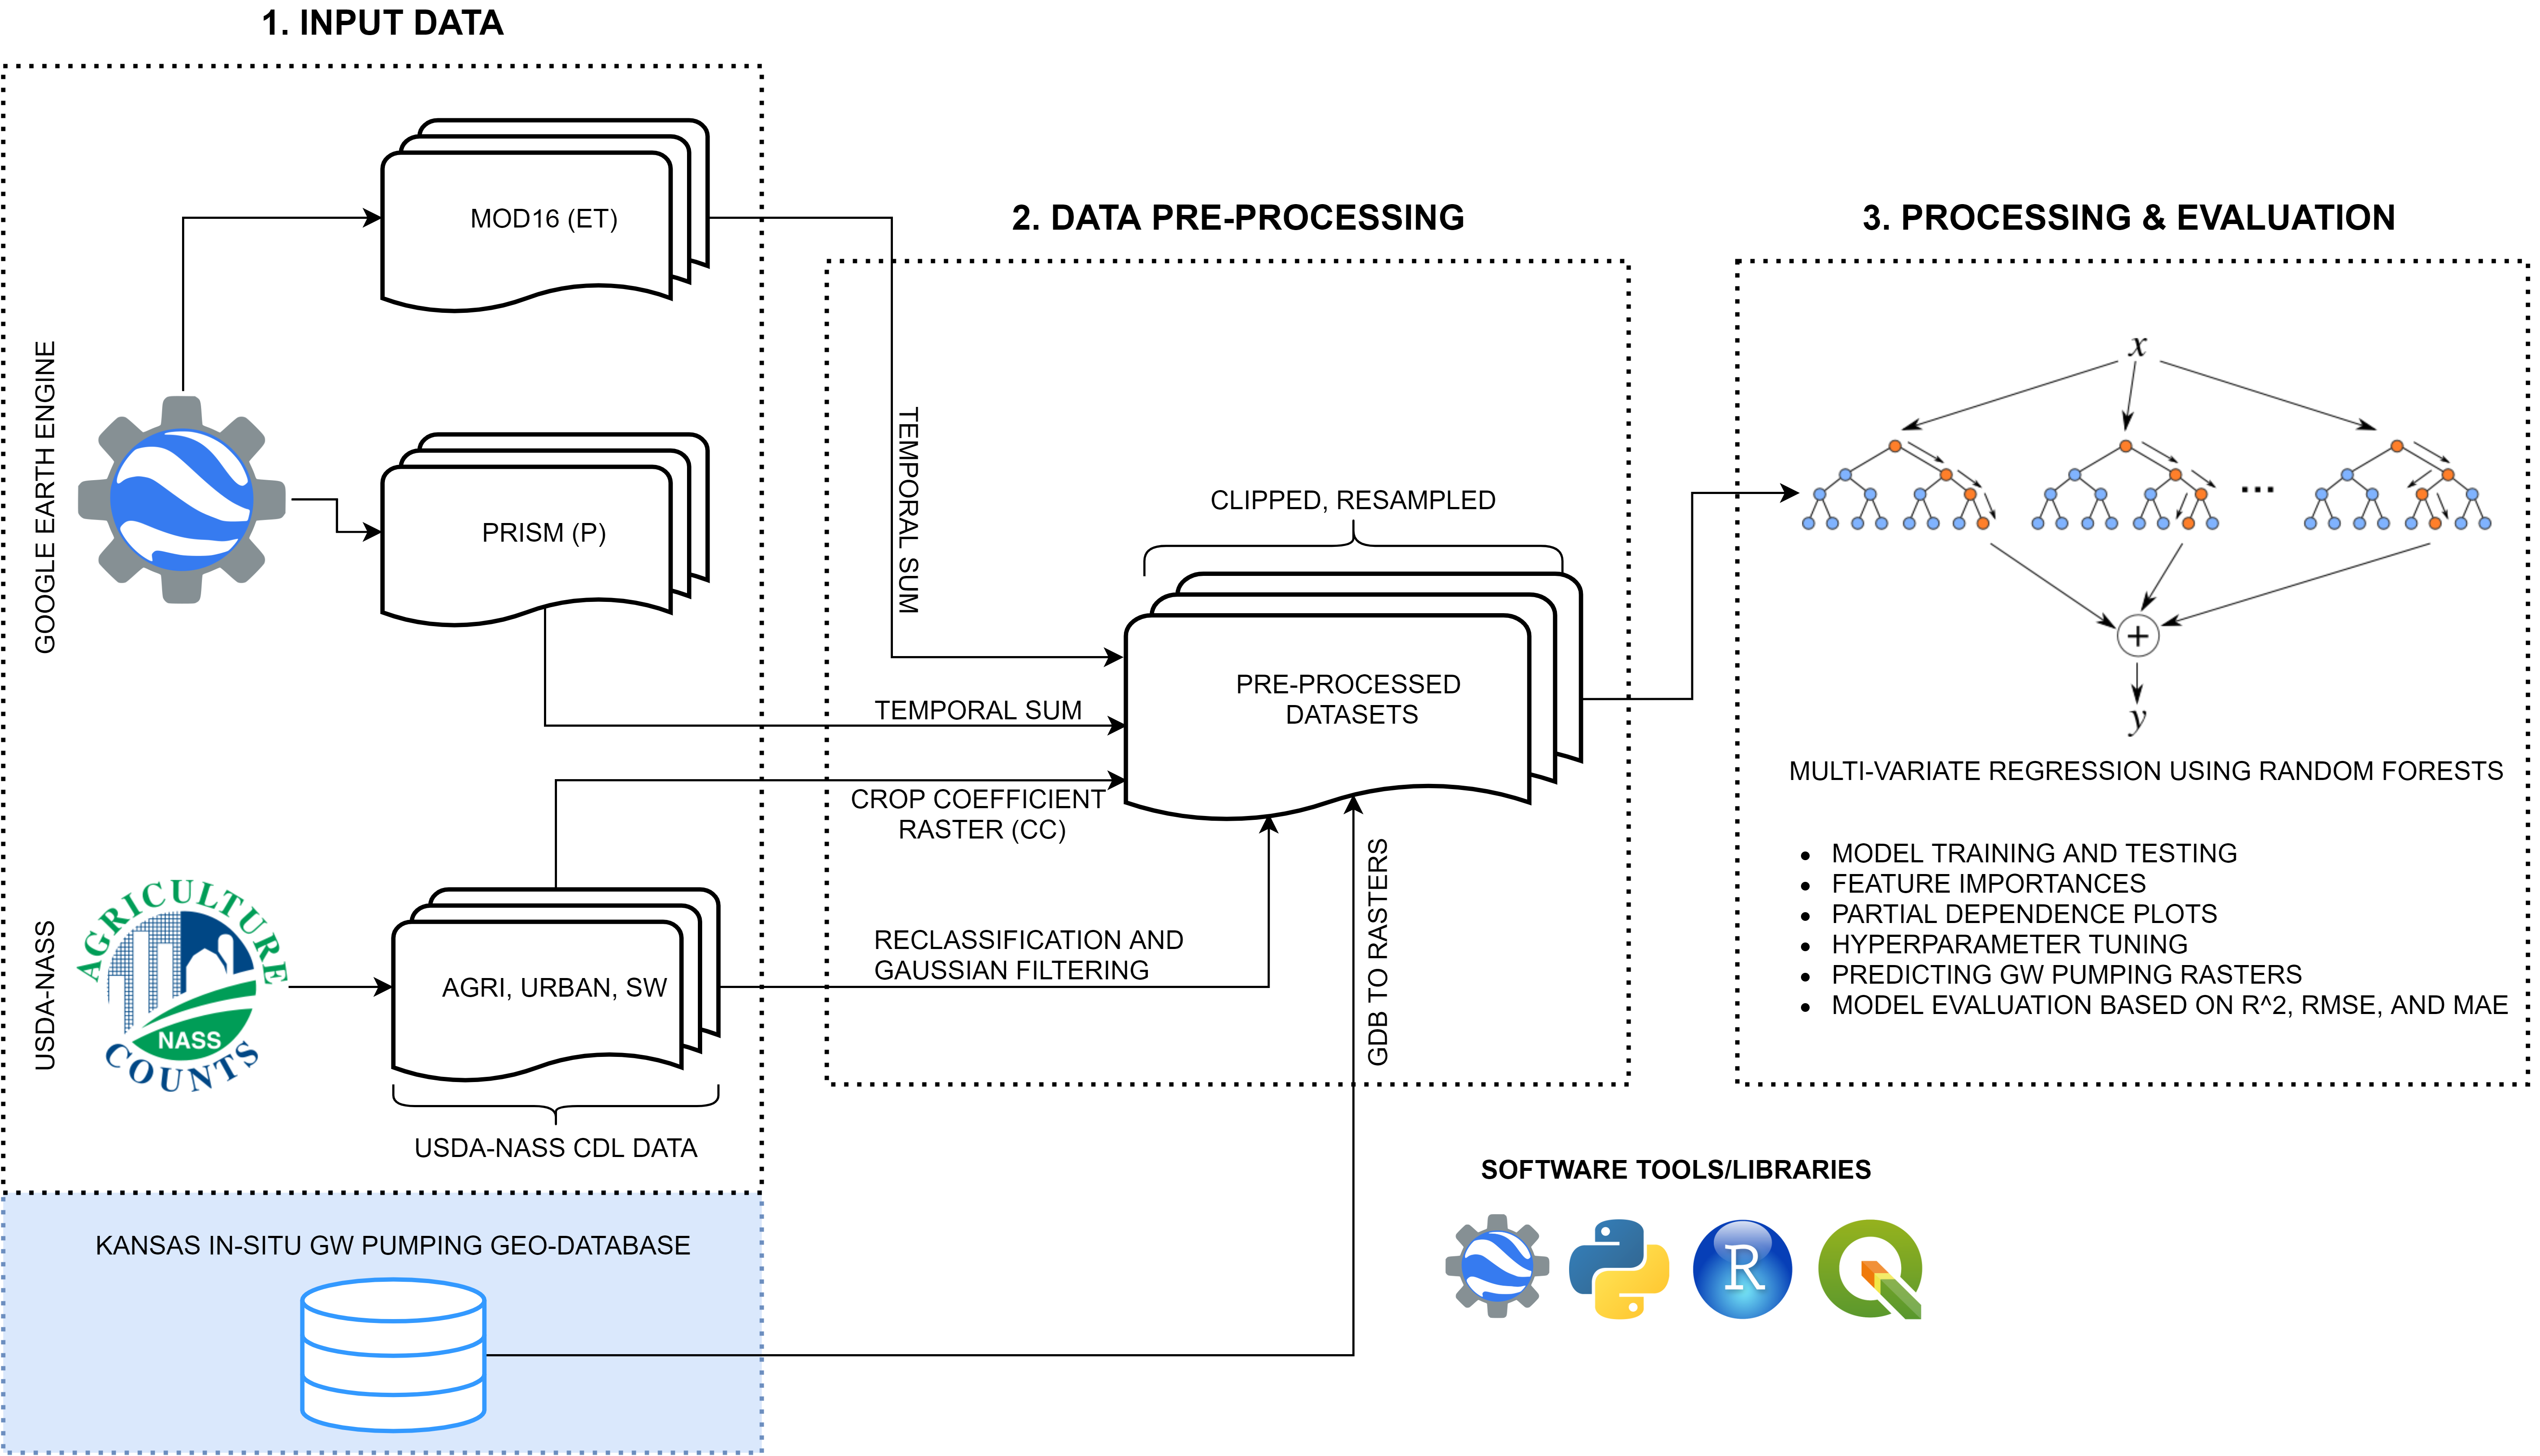

Additional data sets used:

SSEBop Evapotranspiration (ET): https://earlywarning.usgs.gov/ssebop/modis
(MOD16 ET is available only over vegetated surfaces. Since, a large portion of groundwater withdrawals in Arizona occur over urban areas, MOD16 is replaced with SSEBop. However, the workflow I developed allows both of them to be used as predictors.

Crop coefficient look-up table: http://www.fao.org/3/x0490E/x0490e0b.htm
.This is used to adjust the ET values specific to the crops.

GRACE will be used for analyzing the total water storage changes and not as a predictor. For Arizona, I'll be also comparing the predicted groundwater withdrawals with the land subsidence data which I already acquired by requesting the Arizona Department of Water Resources (ADWR) (open data but only provided through email requests).


In [7]:
import pandas as pd

In [97]:
gw_df = pd.read_csv('GW_DF_KS_AZ.csv')
print('Number of data entries (including no data):', gw_df.size)
features = gw_df.columns.values
print('Data dimension:', gw_df.shape)
print('Number of Samples/Rows:', gw_df.shape[0])
print('Number of Features:', gw_df.shape[1])
print('Feature names:', features)
print('Target variable to be predicted:', features[2])
print('\nFeature\tDescription\t\t\t\t\t\t\t\t\t Datatype')
print(features[0], '\tAgriculture density (unitless, normalized between 0 and 1 (inclusive))\t\t', gw_df.AGRI.dtype)
print(features[1], '\tCrop coefficient (unitless)\t\t\t\t\t\t\t', gw_df.Crop.dtype)
print(features[2], '\tAnnual groundwater withdrawals (mm)\t\t\t\t\t\t', gw_df.GW.dtype)
print(features[3], '\tTotal precipitation for the growing season between April to October (mm)\t', gw_df.P.dtype)
print(features[4], '\tSSEBop ET for the growing season between April and October (mm)\t\t\t', gw_df.SSEBop.dtype)
print(features[5], '\tSurface water density (unitless, normalized between 0 and 1 (inclusive))\t', gw_df.SW.dtype)
print(features[6], '\tUrban density (unitless, normalized between 0 and 1 (inclusive))\t\t', gw_df.URBAN.dtype)
print(features[7], '\tYear (2002-2019)\t\t\t\t\t\t\t\t', gw_df.YEAR.dtype)

Number of data entries (including no data): 3088560
Data dimension: (386070, 8)
Number of Samples/Rows: 386070
Number of Features: 8
Feature names: ['AGRI' 'Crop' 'GW' 'P' 'SSEBop' 'SW' 'URBAN' 'YEAR']
Target variable to be predicted: GW

Feature	Description									 Datatype
AGRI 	Agriculture density (unitless, normalized between 0 and 1 (inclusive))		 float64
Crop 	Crop coefficient (unitless)							 float64
GW 	Annual groundwater withdrawals (mm)						 float64
P 	Total precipitation for the growing season between April to October (mm)	 float64
SSEBop 	SSEBop ET for the growing season between April and October (mm)			 float64
SW 	Surface water density (unitless, normalized between 0 and 1 (inclusive))	 float64
URBAN 	Urban density (unitless, normalized between 0 and 1 (inclusive))		 float64
YEAR 	Year (2002-2019)								 int64


In [111]:
na_col = gw_df.isna().sum()
print('Number of NA/Missing values in each column')
print(na_col)
print('\nTotal number of NA/Missing values:', na_col.sum())
num_samples_old = gw_df.shape[0]
gw_df_cleaned = gw_df.dropna()
num_samples_new = gw_df_cleaned.shape[0]
print('\nNumber of rows having missing values removed:', num_samples_old - num_samples_new)

Number of NA/Missing values in each column
AGRI      205292
Crop      207417
GW        205299
P         208284
SSEBop    205292
SW        205292
URBAN     205292
YEAR           0
dtype: int64

Total number of NA/Missing values: 1442168

Number of rows having missing values removed: 208496
